# **Building clusters using K-means in PySpark**

Pyspark in Colab 

In [ ]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://security.ubuntu.com/ub

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

# Data Info

IRIS dataset contains a total of 150 records with 5 columns
(sepal length, sepal width, petal length, petal width, species). There are
50 records for each type of species. We will group them into clusters
without using the species label information

# Step 1: Create the SparkSession

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('K_means').getOrCreate()

# Step 2: Read the Dataset

In [ ]:
df=spark.read.csv('iris_dataset.csv',header=True,inferSchema=True)

# Step 3: Explorary Data Analysis

In [ ]:
#Shape
print((df.count(),len(df.columns)))

(150, 5)


In [ ]:
#Check if we need To change/cast any Columns datatypes
df.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



There is a total of five columns out of which four are numerical and the
label column is categorical.

In [ ]:
from pyspark.sql.functions import rand
df.orderBy(rand()).show(10,False)

+------------+-----------+------------+-----------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species   |
+------------+-----------+------------+-----------+----------+
|4.4         |3.2        |1.3         |0.2        |setosa    |
|5.4         |3.7        |1.5         |0.2        |setosa    |
|5.2         |4.1        |1.5         |0.1        |setosa    |
|7.7         |2.6        |6.9         |2.3        |virginica |
|5.8         |2.7        |5.1         |1.9        |virginica |
|6.3         |3.4        |5.6         |2.4        |virginica |
|6.3         |2.9        |5.6         |1.8        |virginica |
|6.5         |3.2        |5.1         |2.0        |virginica |
|6.6         |2.9        |4.6         |1.3        |versicolor|
|6.3         |2.7        |4.9         |1.8        |virginica |
+------------+-----------+------------+-----------+----------+
only showing top 10 rows



In [ ]:
df.groupBy('species').count().orderBy('count',ascending=False).show()

+----------+-----+
|   species|count|
+----------+-----+
| virginica|   50|
|versicolor|   50|
|    setosa|   50|
+----------+-----+



It confirms that there are an equal number of records for each
species available in the dataset

# Step4 : Feature Engineering

Create a single vector combining all input
features by using Spark’s VectorAssembler(we are not considering a label column
since it's an unsupervised machine learning technique), it essentially
translates it into a single column with four input values in the form
of a list

In [ ]:
df.columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

In [ ]:
from pyspark.ml.feature import VectorAssembler
input_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
vec_assembler = VectorAssembler(inputCols = input_cols,outputCol='features')
final_data = vec_assembler.transform(df)


# Step 5 : Build K-Means Clustering Model

**We need to declare the value of ‘K’ in advance before
using K-means**
- Use elbow method to figure out the right value
of ‘K’. 


-

To use the elbow method, we run K-means clustering for
different values of ‘K’. First, we import K-means from the PySpark library
and create an empty list that would capture the variability or SSE (within
cluster distance) for each value of K

In [ ]:
from pyspark.ml.clustering import KMeans
errors = []
#the ‘K’ should have a minimum value of 2 to be able to build clusters.
for k in range(2,10):#Start,end
  kmeans = KMeans(featuresCol='features',k=k)
  model = kmeans.fit(final_data)
  intra_distance = model.computeCost(final_data)
  errors.append(intra_distance)
  


Plot the intracluster distance with the number of clusters
using numpy and matplotlib.

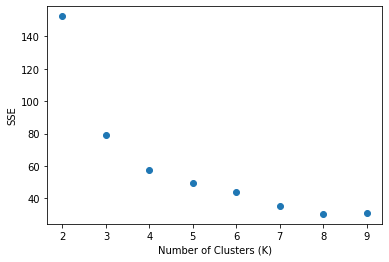

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
cluster_number = range(2,10)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.scatter(cluster_number,errors)
plt.show()


**K=3** seems to be the best number of clusters as we can see
a sort of elbow formation between three and four values.

In [ ]:
#We build final clusters using k=3.

kmeans = KMeans(featuresCol='features',k=3)
model = kmeans.fit(final_data)


In [ ]:
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   39|
|         0|   61|
+----------+-----+



K-Means clustering gives us three different clusters based on the IRIS
data set. We certainly are making a few of the allocations wrong as only
one category has 50 records in the group, and the rest of the categories
are mixed up. We can use the transform function to assign the cluster
number to the original dataset and use a groupBy function to validate the
groupings.

In [ ]:
predictions = model.transform(final_data)
predictions.groupBy('species','prediction').count().show()

+----------+----------+-----+
|   species|prediction|count|
+----------+----------+-----+
| virginica|         2|   36|
| virginica|         0|   14|
|versicolor|         0|   47|
|    setosa|         1|   50|
|versicolor|         2|    3|
+----------+----------+-----+



As it can be observed, the setosa species is perfectly grouped
along with versicolor, almost being captured in the same cluster,
but verginica seems to fall within two different groups. 

# Step 6: Visualization of Clusters


In [ ]:
#convert Spark dataset to Pandas 
pandas_df = predictions.toPandas()
pandas_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,features,prediction
0,5.1,3.5,1.4,0.2,setosa,"[5.1, 3.5, 1.4, 0.2]",1
1,4.9,3.0,1.4,0.2,setosa,"[4.9, 3.0, 1.4, 0.2]",1
2,4.7,3.2,1.3,0.2,setosa,"[4.7, 3.2, 1.3, 0.2]",1
3,4.6,3.1,1.5,0.2,setosa,"[4.6, 3.1, 1.5, 0.2]",1
4,5.0,3.6,1.4,0.2,setosa,"[5.0, 3.6, 1.4, 0.2]",1


We import the required libraries to plot the third visualization and
observe the clusters.

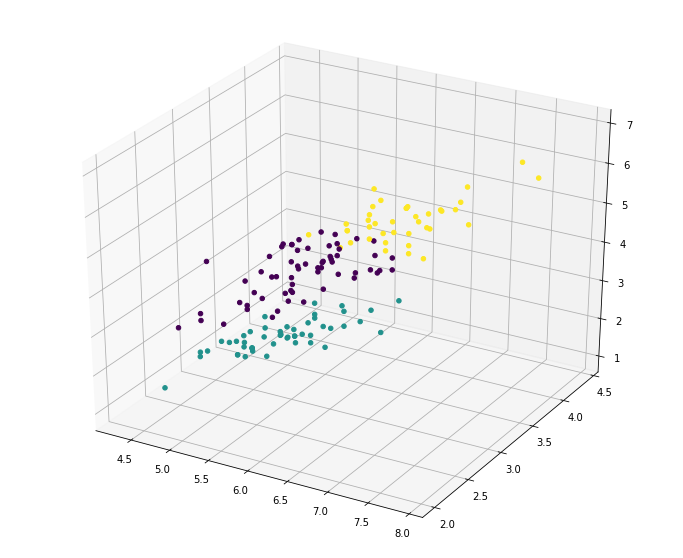

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
cluster_vis = plt.figure(figsize=(12,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.sepal_length, pandas_df.sepal_width, pandas_df.petal_length, c=pandas_df.prediction,depthshade=False)
plt.show()